In [6]:
from keras import backend as K

def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score



In [11]:
#1) 기본 딥러닝으로 학습성과 예측 모델 구현하기
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import pandas as pd
import numpy
import tensorflow as tf
import matplotlib.pyplot as plt
import os


# seed 값 설정
seed = 0
numpy.random.seed(seed)
tf.set_random_seed(seed)

# 데이터 입력
df_pre = pd.read_csv('./dataset/0706_2.csv', header=None)
df = df_pre.sample(frac=0.3)
print(df_pre.info())

#28831건 컬럼 total 12 columns 0~11


#2) data 설정
dataset = df.values
X = dataset[:,0:11]
Y = dataset[:,11]

# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

# 훈련 데이터와 테스트 데이터로 분리하기
X_train, X_test, y_train, y_test = train_test_split(X, Y)

cvscores = []
# 모델 저장 폴더 만들기
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath="./model/{epoch:02d}-{val_loss:.4f}.hdf5"


for train, test in kfold.split(X, Y):
    
    #create model
    model = Sequential()
    model.add(Dense(30, input_dim=11,activation='relu'))
    model.add(Dense(9,activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
   #모델 컴파일
    model.compile(loss='binary_crossentropy',
           optimizer='adam',metrics=['accuracy', precision, recall, f1score])
    
    # 모델 업데이트 및 저장
    checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
    #에포크가 진행되면서 모든 값이 저장되는 것이 아니라 테스트 오차를 실행한 결괏값이 향상되었을 때만 저장됨.
    df = df_pre.sample(frac=1)
    
    # Fit the model
    model.fit(X[train], Y[train], validation_split=0.2, epochs=200, batch_size=200, verbose=0, callbacks=[checkpointer])
    # evaluate the model
    scores = model.evaluate(X[test], Y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28832 entries, 0 to 28831
Data columns (total 12 columns):
0     28832 non-null int64
1     28832 non-null int64
2     28832 non-null int64
3     28832 non-null float64
4     28832 non-null int64
5     28832 non-null int64
6     28832 non-null int64
7     28832 non-null int64
8     28832 non-null float64
9     28832 non-null float64
10    28832 non-null float64
11    28832 non-null int64
dtypes: float64(4), int64(8)
memory usage: 2.6 MB
None

Epoch 00001: val_loss improved from inf to 2.33206, saving model to ./model/01-2.3321.hdf5

Epoch 00002: val_loss improved from 2.33206 to 2.06114, saving model to ./model/02-2.0611.hdf5

Epoch 00003: val_loss improved from 2.06114 to 1.13970, saving model to ./model/03-1.1397.hdf5

Epoch 00004: val_loss improved from 1.13970 to 1.00511, saving model to ./model/04-1.0051.hdf5

Epoch 00005: val_loss improved from 1.00511 to 0.88951, saving model to ./model/05-0.8895.hdf5

Epoch 00006: val_loss did n


Epoch 00168: val_loss did not improve

Epoch 00169: val_loss did not improve

Epoch 00170: val_loss did not improve

Epoch 00171: val_loss did not improve

Epoch 00172: val_loss did not improve

Epoch 00173: val_loss did not improve

Epoch 00174: val_loss did not improve

Epoch 00175: val_loss did not improve

Epoch 00176: val_loss did not improve

Epoch 00177: val_loss did not improve

Epoch 00178: val_loss did not improve

Epoch 00179: val_loss did not improve

Epoch 00180: val_loss improved from 0.45330 to 0.45262, saving model to ./model/180-0.4526.hdf5

Epoch 00181: val_loss did not improve

Epoch 00182: val_loss did not improve

Epoch 00183: val_loss did not improve

Epoch 00184: val_loss did not improve

Epoch 00185: val_loss did not improve

Epoch 00186: val_loss did not improve

Epoch 00187: val_loss did not improve

Epoch 00188: val_loss did not improve

Epoch 00189: val_loss did not improve

Epoch 00190: val_loss did not improve

Epoch 00191: val_loss did not improve

Epoch


Epoch 00150: val_loss did not improve

Epoch 00151: val_loss did not improve

Epoch 00152: val_loss did not improve

Epoch 00153: val_loss did not improve

Epoch 00154: val_loss did not improve

Epoch 00155: val_loss did not improve

Epoch 00156: val_loss did not improve

Epoch 00157: val_loss did not improve

Epoch 00158: val_loss did not improve

Epoch 00159: val_loss did not improve

Epoch 00160: val_loss did not improve

Epoch 00161: val_loss did not improve

Epoch 00162: val_loss did not improve

Epoch 00163: val_loss did not improve

Epoch 00164: val_loss did not improve

Epoch 00165: val_loss did not improve

Epoch 00166: val_loss did not improve

Epoch 00167: val_loss did not improve

Epoch 00168: val_loss did not improve

Epoch 00169: val_loss did not improve

Epoch 00170: val_loss did not improve

Epoch 00171: val_loss did not improve

Epoch 00172: val_loss did not improve

Epoch 00173: val_loss did not improve

Epoch 00174: val_loss did not improve

Epoch 00175: val_loss im


Epoch 00161: val_loss did not improve

Epoch 00162: val_loss did not improve

Epoch 00163: val_loss did not improve

Epoch 00164: val_loss did not improve

Epoch 00165: val_loss did not improve

Epoch 00166: val_loss did not improve

Epoch 00167: val_loss did not improve

Epoch 00168: val_loss did not improve

Epoch 00169: val_loss did not improve

Epoch 00170: val_loss did not improve

Epoch 00171: val_loss did not improve

Epoch 00172: val_loss did not improve

Epoch 00173: val_loss did not improve

Epoch 00174: val_loss did not improve

Epoch 00175: val_loss did not improve

Epoch 00176: val_loss did not improve

Epoch 00177: val_loss did not improve

Epoch 00178: val_loss did not improve

Epoch 00179: val_loss did not improve

Epoch 00180: val_loss did not improve

Epoch 00181: val_loss did not improve

Epoch 00182: val_loss did not improve

Epoch 00183: val_loss did not improve

Epoch 00184: val_loss did not improve

Epoch 00185: val_loss did not improve

Epoch 00186: val_loss di


Epoch 00174: val_loss did not improve

Epoch 00175: val_loss did not improve

Epoch 00176: val_loss did not improve

Epoch 00177: val_loss did not improve

Epoch 00178: val_loss did not improve

Epoch 00179: val_loss did not improve

Epoch 00180: val_loss did not improve

Epoch 00181: val_loss did not improve

Epoch 00182: val_loss did not improve

Epoch 00183: val_loss did not improve

Epoch 00184: val_loss did not improve

Epoch 00185: val_loss did not improve

Epoch 00186: val_loss did not improve

Epoch 00187: val_loss did not improve

Epoch 00188: val_loss did not improve

Epoch 00189: val_loss did not improve

Epoch 00190: val_loss did not improve

Epoch 00191: val_loss did not improve

Epoch 00192: val_loss did not improve

Epoch 00193: val_loss did not improve

Epoch 00194: val_loss did not improve

Epoch 00195: val_loss did not improve

Epoch 00196: val_loss did not improve

Epoch 00197: val_loss did not improve

Epoch 00198: val_loss did not improve

Epoch 00199: val_loss di


Epoch 00151: val_loss did not improve

Epoch 00152: val_loss did not improve

Epoch 00153: val_loss did not improve

Epoch 00154: val_loss did not improve

Epoch 00155: val_loss did not improve

Epoch 00156: val_loss improved from 0.44955 to 0.44567, saving model to ./model/156-0.4457.hdf5

Epoch 00157: val_loss did not improve

Epoch 00158: val_loss did not improve

Epoch 00159: val_loss improved from 0.44567 to 0.44489, saving model to ./model/159-0.4449.hdf5

Epoch 00160: val_loss did not improve

Epoch 00161: val_loss did not improve

Epoch 00162: val_loss did not improve

Epoch 00163: val_loss did not improve

Epoch 00164: val_loss did not improve

Epoch 00165: val_loss did not improve

Epoch 00166: val_loss did not improve

Epoch 00167: val_loss did not improve

Epoch 00168: val_loss did not improve

Epoch 00169: val_loss did not improve

Epoch 00170: val_loss did not improve

Epoch 00171: val_loss did not improve

Epoch 00172: val_loss improved from 0.44489 to 0.44402, saving m


Epoch 00143: val_loss did not improve

Epoch 00144: val_loss did not improve

Epoch 00145: val_loss did not improve

Epoch 00146: val_loss did not improve

Epoch 00147: val_loss did not improve

Epoch 00148: val_loss did not improve

Epoch 00149: val_loss did not improve

Epoch 00150: val_loss did not improve

Epoch 00151: val_loss did not improve

Epoch 00152: val_loss did not improve

Epoch 00153: val_loss did not improve

Epoch 00154: val_loss did not improve

Epoch 00155: val_loss did not improve

Epoch 00156: val_loss did not improve

Epoch 00157: val_loss did not improve

Epoch 00158: val_loss did not improve

Epoch 00159: val_loss did not improve

Epoch 00160: val_loss did not improve

Epoch 00161: val_loss did not improve

Epoch 00162: val_loss did not improve

Epoch 00163: val_loss did not improve

Epoch 00164: val_loss did not improve

Epoch 00165: val_loss did not improve

Epoch 00166: val_loss did not improve

Epoch 00167: val_loss did not improve

Epoch 00168: val_loss di


Epoch 00132: val_loss did not improve

Epoch 00133: val_loss did not improve

Epoch 00134: val_loss did not improve

Epoch 00135: val_loss did not improve

Epoch 00136: val_loss did not improve

Epoch 00137: val_loss did not improve

Epoch 00138: val_loss did not improve

Epoch 00139: val_loss did not improve

Epoch 00140: val_loss did not improve

Epoch 00141: val_loss did not improve

Epoch 00142: val_loss did not improve

Epoch 00143: val_loss did not improve

Epoch 00144: val_loss did not improve

Epoch 00145: val_loss did not improve

Epoch 00146: val_loss did not improve

Epoch 00147: val_loss did not improve

Epoch 00148: val_loss did not improve

Epoch 00149: val_loss did not improve

Epoch 00150: val_loss did not improve

Epoch 00151: val_loss did not improve

Epoch 00152: val_loss did not improve

Epoch 00153: val_loss did not improve

Epoch 00154: val_loss did not improve

Epoch 00155: val_loss did not improve

Epoch 00156: val_loss did not improve

Epoch 00157: val_loss di


Epoch 00119: val_loss did not improve

Epoch 00120: val_loss did not improve

Epoch 00121: val_loss did not improve

Epoch 00122: val_loss did not improve

Epoch 00123: val_loss did not improve

Epoch 00124: val_loss did not improve

Epoch 00125: val_loss did not improve

Epoch 00126: val_loss did not improve

Epoch 00127: val_loss did not improve

Epoch 00128: val_loss improved from 0.45164 to 0.45009, saving model to ./model/128-0.4501.hdf5

Epoch 00129: val_loss did not improve

Epoch 00130: val_loss did not improve

Epoch 00131: val_loss did not improve

Epoch 00132: val_loss improved from 0.45009 to 0.44933, saving model to ./model/132-0.4493.hdf5

Epoch 00133: val_loss did not improve

Epoch 00134: val_loss did not improve

Epoch 00135: val_loss did not improve

Epoch 00136: val_loss did not improve

Epoch 00137: val_loss did not improve

Epoch 00138: val_loss did not improve

Epoch 00139: val_loss did not improve

Epoch 00140: val_loss did not improve

Epoch 00141: val_loss did


Epoch 00122: val_loss did not improve

Epoch 00123: val_loss did not improve

Epoch 00124: val_loss did not improve

Epoch 00125: val_loss did not improve

Epoch 00126: val_loss did not improve

Epoch 00127: val_loss did not improve

Epoch 00128: val_loss did not improve

Epoch 00129: val_loss did not improve

Epoch 00130: val_loss did not improve

Epoch 00131: val_loss did not improve

Epoch 00132: val_loss did not improve

Epoch 00133: val_loss did not improve

Epoch 00134: val_loss did not improve

Epoch 00135: val_loss did not improve

Epoch 00136: val_loss did not improve

Epoch 00137: val_loss did not improve

Epoch 00138: val_loss did not improve

Epoch 00139: val_loss did not improve

Epoch 00140: val_loss did not improve

Epoch 00141: val_loss did not improve

Epoch 00142: val_loss did not improve

Epoch 00143: val_loss did not improve

Epoch 00144: val_loss did not improve

Epoch 00145: val_loss did not improve

Epoch 00146: val_loss did not improve

Epoch 00147: val_loss di


Epoch 00104: val_loss improved from 0.47101 to 0.47031, saving model to ./model/104-0.4703.hdf5

Epoch 00105: val_loss did not improve

Epoch 00106: val_loss did not improve

Epoch 00107: val_loss did not improve

Epoch 00108: val_loss did not improve

Epoch 00109: val_loss did not improve

Epoch 00110: val_loss did not improve

Epoch 00111: val_loss did not improve

Epoch 00112: val_loss did not improve

Epoch 00113: val_loss did not improve

Epoch 00114: val_loss did not improve

Epoch 00115: val_loss did not improve

Epoch 00116: val_loss did not improve

Epoch 00117: val_loss did not improve

Epoch 00118: val_loss did not improve

Epoch 00119: val_loss did not improve

Epoch 00120: val_loss did not improve

Epoch 00121: val_loss did not improve

Epoch 00122: val_loss did not improve

Epoch 00123: val_loss did not improve

Epoch 00124: val_loss did not improve

Epoch 00125: val_loss did not improve

Epoch 00126: val_loss did not improve

Epoch 00127: val_loss did not improve

Epoch

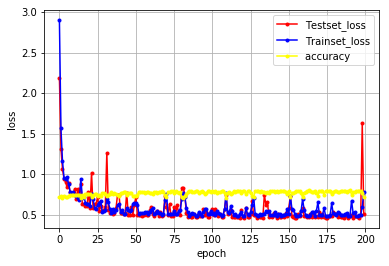

loss: 0.498, accuracy: 0.805, precision: 0.829, recall: 0.941, f1score: 0.881


In [8]:
# y_acc에 학습셋으로 측정한 정확도의 값을 저장
y_acc=history.history['acc']

# 테스트셋의 오차
y_vloss = history.history['val_loss']

# 학습셋의 오차
y_loss = history.history['loss']
from sklearn import svm, metrics, model_selection

# 그래프로 표현
x_len = numpy.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')
plt.plot(x_len, y_acc, marker='.', c="yellow", label='accuracy ')

# 그래프에 그리드를 주고 레이블을 표시
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

_loss, _acc, _precision, _recall, _f1score = model.evaluate(X_test, y_test, batch_size=200, verbose=0)
print('loss: {:.3f}, accuracy: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _precision, _recall, _f1score))





In [94]:
# 데이터 입력
df_testset = pd.read_csv('./dataset/testset.csv', header=None)
#2) data 설정
dataset11= df_testset.values
X_df_testset = dataset11[:,0:11]

# 예측 값과 실제 값의 비교
Y_prediction = model.predict(X)

  
print(Y_prediction[9])

[1.]
